# Results for 200 development set abstracts

Tong Shu Li<br>
Created on: 2015-08-24<br>
Last updated: 2015-08-25

Despite the fact that we had cheaters for the abstract-level task for the 200 abstracts, we should see how well we did overall.

In [1]:
from collections import Counter
from collections import defaultdict
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle

In [2]:
matplotlib inline

In [3]:
from src.filter_data import filter_data
from src.data_model import parse_input
from src.data_model import Relation
from src.data_model import is_MeSH_id
from src.get_AUC_value import get_AUC_value
from src.F_score import *
from src.aggregate_results import *

In [4]:
from src.lingpipe.file_util import read_file

---

### Read the gold standard:

In [5]:
def read_gold_standard(dataset, file_format = "list"):
    assert dataset in ["training", "development"]
    assert file_format in ["list", "dict"]
    
    fname = "data/gold_standard/parsed_{0}_set_{1}.pickle".format(dataset, file_format)
    
    if os.path.exists(fname):
        print("Reading cached version of {0} set ({1})".format(dataset, file_format))
        
        with open(fname, "rb") as fin:
            data = pickle.load(fin)
    else:
        print("Parsing raw {0} file".format(dataset))
        data = parse_input("data/gold_standard".format(dataset),
                           "CDR_{0}Set.txt".format(dataset.capitalize()),
                           is_gold = True,
                           return_format = file_format,
                          fix_acronyms = False)
        
        with open(fname, "wb") as fout:
            pickle.dump(data, fout)
            
    return data

In [6]:
dev_gold = read_gold_standard("development", "dict")

Reading cached version of development set (dict)


In [7]:
def in_gold(row):
    pmid = int(row["pmid"])
    return int(dev_gold[pmid].has_relation(Relation(pmid, row["chemical_id"], row["disease_id"])))

In [8]:
testset_pmids = {48362,
 85485,
 188339,
 326460,
 384871,
 430165,
 458486,
 625456,
 663266,
 761833,
 871943,
 921394,
 982002,
 1255900,
 1355091,
 1504402,
 1687392,
 1899352,
 1928887,
 1969772,
 2004015,
 2021202,
 2051906,
 2320800,
 2339463,
 2435991,
 2564649,
 2576810,
 2716967,
 2722224,
 2790457,
 2840807,
 2886572,
 2893236,
 2980315,
 3084782,
 3108839,
 3115150,
 3123611,
 3131282,
 3137399,
 3183120,
 3411101,
 3413271,
 3670965,
 3686155,
 3703509,
 3732088,
 3762968,
 3769769,
 3780697,
 3780814,
 3934126,
 3950060,
 3952818,
 3961813,
 3962737,
 3973521,
 4038130,
 4090988,
 6127992,
 6150641,
 6293644,
 6323692,
 6454943,
 6540303,
 6615052,
 6637851,
 6699841,
 6732043,
 6769133,
 6892185,
 7007443,
 7053705,
 7072798,
 7282516,
 7604176,
 7619765,
 7647582,
 7650771,
 7710775,
 7752389,
 7803371,
 7843916,
 8012887,
 8106150,
 8111719,
 8251368,
 8267029,
 8268147,
 8494478,
 8586822,
 8617710,
 8766220,
 8888541,
 8911359,
 8958188,
 9098464,
 9209318,
 9214597,
 9226773,
 9305828,
 9545159,
 9549528,
 9564988,
 9672273,
 9867728,
 9875685,
 9952311,
 10074612,
 10193809,
 10225068,
 10354657,
 10411803,
 10414674,
 10524660,
 10539815,
 10565806,
 10692744,
 10840460,
 11009181,
 11063349,
 11079278,
 11185967,
 11195262,
 11208990,
 11230490,
 11302406,
 11337188,
 11694026,
 11705128,
 11847945,
 11860495,
 12013711,
 12091028,
 12093990,
 12231232,
 12448656,
 12600698,
 12691807,
 12734532,
 12739036,
 12851669,
 12907924,
 14736955,
 14975762,
 14982270,
 15042318,
 15075188,
 15096016,
 15579441,
 15673851,
 15814210,
 15867025,
 15893386,
 15897593,
 15974569,
 15985056,
 16006300,
 16047871,
 16157917,
 16418614,
 16428827,
 16574713,
 16586083,
 16710500,
 16820346,
 17285209,
 17366349,
 17490790,
 17490864,
 17574447,
 17682013,
 17786501,
 17943461,
 17965424,
 18006530,
 18086064,
 18201582,
 18356633,
 18441470,
 18483878,
 18589141,
 18657397,
 18674790,
 18997632,
 19105845,
 19234905,
 19274460,
 19674115,
 19707748,
 19721134,
 19893084,
 19940105,
 19944736,
 20164825,
 20533999,
 20552622,
 20727411,
 20735774}

In [9]:
ner_devset = parse_input("data/gold_standard", "processed_CDR_devset.txt",
                        is_gold = False, return_format = "dict", fix_acronyms = True)

In [10]:
gold_testset = {pmid : dev_gold[pmid] for pmid in testset_pmids}

In [11]:
def flat_repr(id_set):
    vals = ["{0}:{1}".format(v.uid_type, v.uid) for v in id_set]
    return "|".join(sorted(vals))

In [12]:
temp = defaultdict(list)
for pmid in testset_pmids:
    paper = ner_devset[pmid]
    for sentence in paper.sentences:
        work = sentence.poss_relations[False] - paper.poss_relations["CID"]
        
        for chem_ids, dise_ids in work:
            assert len(chem_ids) == 1
            assert len(dise_ids) == 1
            temp["pmid"].append(pmid)
            temp["chemical_id"].append(flat_repr(chem_ids))
            temp["disease_id"].append(flat_repr(dise_ids))
            temp["sentence_id"].append(sentence.uid)
        
        # grab the list of ones which would have been generated
        # use it to filter out the crowd results
        for chem_ids, dise_ids in paper.poss_relations["not_sentence_bound"]:
            assert len(dise_ids) == 1
            assert len(chem_ids) == 1
            temp["pmid"].append(pmid)
            temp["chemical_id"].append(flat_repr(chem_ids))
            temp["disease_id"].append(flat_repr(dise_ids))
            temp["sentence_id"].append("unknown")
        
ner_findable = pd.DataFrame(temp)

In [13]:
ner_findable.head()

,chemical_id,disease_id,pmid,sentence_id
0,MESH:D015742,MESH:D010146,18006530,18006530_0
1,MESH:C071741,MESH:D010146,18006530,18006530_0
2,MESH:D015742,MESH:D010146,18006530,18006530_1
3,MESH:D015742,MESH:D010146,18006530,18006530_2
4,MESH:C071741,MESH:D010146,18006530,18006530_2


In [14]:
ner_findable.shape

(11978, 4)

### Sentence-level task results:

In [15]:
id_map = pd.read_csv("data/gold_standard/id_mapping.tsv", sep = '\t')

In [16]:
id_map.head()

,uniq_id,sentence_id
0,bcv_easy_0,15579441_4
1,bcv_easy_1,15579441_5
2,bcv_easy_2,18006530_0
3,bcv_easy_3,18006530_0
4,bcv_easy_4,18006530_1


In [17]:
sent_id_map = dict()
for idx, row in id_map.iterrows():
    sent_id_map[row["uniq_id"]] = row["sentence_id"]

In [18]:
settings = {
    "loc": "data/crowdflower/results",
    "fname": "job_761593_full_with_untrusted.csv",
    "data_subset": "normal",
    "min_accuracy": 0.7,
    "max_accuracy": 1.0
}

sent_raw_data = filter_data(settings)

In [19]:
sent_raw_data["sentence_id"] = sent_raw_data["uniq_id"].map(lambda v: sent_id_map[v])

In [20]:
def can_find(row):
    """Can we make this with the NER output?"""
    dis_ids = row["disease_id"].split("|")
    
    for dis_id in dis_ids:
        dise_id = "MESH:{0}".format(dis_id)
        chem_id = "MESH:{0}".format(row["chemical_id"])
        
        res = ner_findable.query("sentence_id == '{0}' and pmid == {1} and chemical_id == '{2}' and disease_id == '{3}'".format(row["sentence_id"], row["pmid"],
                                                    chem_id, dise_id))
        
        if len(res) == 0:
            return False
        
    return True

sent_raw_data["findable"] = sent_raw_data.loc[:, ["pmid", "chemical_id", "disease_id", "sentence_id"]].apply(can_find, axis = 1)

---

In [21]:
sent_raw_data = sent_raw_data.query("~_tainted")

In [22]:
sent_raw_data.shape

(5500, 33)

In [23]:
sent_work_votes = defaultdict(set)
for uniq_id, group in sent_raw_data.groupby("uniq_id"):
    sent_work_votes[len(group["_worker_id"].unique())].add(uniq_id)
    
for votes, units in sent_work_votes.items():
    print("Judgements {0}, # of work units: {1}".format(votes, len(units)))

Judgements 1, # of work units: 15
Judgements 2, # of work units: 11
Judgements 3, # of work units: 12
Judgements 4, # of work units: 57
Judgements 5, # of work units: 1035
Judgements 6, # of work units: 4


In [24]:
units = list(sent_work_votes[4] | sent_work_votes[5] | sent_work_votes[6])

sent_raw_data = sent_raw_data.query("uniq_id in {0}".format(units))

In [25]:
sent_raw_data.shape

(5427, 33)

In [26]:
# take positive votes only, indirect is no
sent_res_pos_no = aggregate_results("uniq_id", "verify_relationship", sent_raw_data,
                                    "positive_signal_only",
                                     ["pmid", "_unit_id", "chemical_id", "disease_id", "relation_pair_id", "sentence_id", "findable"],
                                    "yes_direct", {"yes_indirect" : "no_relation", "ner_mistake": "no_relation"})

In [27]:
sent_res_pos_no["in_gold"] = sent_res_pos_no.loc[:, ["pmid", "chemical_id", "disease_id"]].apply(in_gold, axis = 1)

In [28]:
sent_res_pos_no.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,chemical_id,disease_id,relation_pair_id,sentence_id,findable,in_gold
1,bcv_easy_0,yes_direct,0.7353,1,0.181162,15579441,769152007,D011692,D000860,15579441_D011692_D000860,15579441_4,True,1
0,bcv_easy_0,no_relation,3.3235,4,0.818838,15579441,769152007,D011692,D000860,15579441_D011692_D000860,15579441_4,True,1
1,bcv_easy_1,yes_direct,1.5294,2,0.374101,15579441,769152008,D011692,D000860,15579441_D011692_D000860,15579441_5,True,1
0,bcv_easy_1,no_relation,2.5588,3,0.625899,15579441,769152008,D011692,D000860,15579441_D011692_D000860,15579441_5,True,1
1,bcv_easy_10,yes_direct,0.8529,1,0.218038,18006530,769152017,D015742,D010146,18006530_D015742_D010146,18006530_11,True,1


In [29]:
sent_res_pos_no = sent_res_pos_no.query("verify_relationship == 'yes_direct'")

In [30]:
def aggregate_sentences(sentence_res):
    """
    Given the aggregated results at the individual work unit level,
    this function determines which sentence-bound drug-disease relationships
    are true at the abstract level.
    """
    res = defaultdict(list)
    for info, group in sentence_res.groupby(["pmid", "chemical_id", "disease_id"]):
        norm_conf_score_max = group["percent_agree"].max()
        
        res["pmid"].append(info[0])
        res["chemical_id"].append(info[1])
        res["disease_id"].append(info[2])
        
        res["in_gold"].append(group["in_gold"].iloc[0])
        
        res["num_votes"].append(group["num_votes"].max())
        res["norm_conf_score"].append(norm_conf_score_max)
        
        res["uniq_ids"].append("|".join(group["uniq_id"].unique()))
        res["unit_ids"].append("|".join(map(lambda x: str(int(x)), group["unit_id"].unique())))
        res["sentence_ids"].append("|".join(group["sentence_id"].unique()))
        
    return pd.DataFrame(res)

In [31]:
sent_perf_no = aggregate_sentences(sent_res_pos_no)

In [32]:
sent_perf_no.head()

,chemical_id,disease_id,in_gold,norm_conf_score,num_votes,pmid,sentence_ids,uniq_ids,unit_ids
0,D011802,D056486,1,0.586471,3,48362,48362_0,bcv_easy_1155,769153162
1,C012282,D006528,0,0.000000,0,85485,85485_2,bcv_easy_382,769152389
2,C012282,D009369,0,0.000000,0,85485,85485_2,bcv_easy_381,769152388
3,D001556,D006528,1,1.000000,5,85485,85485_0|85485_1,bcv_easy_378|bcv_easy_379,769152385|769152386
4,D001556,D017093,0,0.807094,4,85485,85485_1,bcv_easy_380,769152387


---

### Abstract-level task results

In [33]:
settings = {
    "loc": "data/crowdflower/results",
    "fname": "job_758438_full_with_untrusted.csv",
    "data_subset": "normal",
    "min_accuracy": 0.7,
    "max_accuracy": 1.0
}

abs_raw_data = filter_data(settings)

In [34]:
bad_workers = {
 31501233,
 31720388,
 31720815,
 32025293,
 33081102,
 33081299,
 33081469,
 33081531,
 33085305,
 33085428,
 33238902,
 33301062,
 33301138,
 33596095}

In [35]:
clean_abs_data = abs_raw_data.query("_worker_id not in {0}".format(list(bad_workers)))

In [36]:
clean_abs_data.shape

(3709, 29)

In [37]:
# how many work units have fewer than 5 votes?
unit_votes = defaultdict(set)
for uniq_id, group in clean_abs_data.groupby("uniq_id"):
    total_votes = len(group["_worker_id"].unique())
    unit_votes[total_votes].add(uniq_id)
    
for votes, ids in unit_votes.items():
    print(votes, len(ids))

1 67
2 186
3 273
4 219
5 315


In [38]:
good_units = unit_votes[3] | unit_votes[4] | unit_votes[5]
clean_abs_data = clean_abs_data.query("uniq_id in {0}".format(list(good_units)))

In [39]:
def can_find_abs(row):
    """Can we make this with the NER output?"""
    dis_ids = row["disease_id"].split("|")
    
    for dis_id in dis_ids:
        dise_id = "MESH:{0}".format(dis_id)
        chem_id = "MESH:{0}".format(row["chemical_id"])
        
        res = ner_findable.query("pmid == {0} and chemical_id == '{1}' and disease_id == '{2}'".format(row["pmid"],
                                                    chem_id, dise_id))
        
        if len(res) > 0:
            return True
        
    return False

clean_abs_data["findable"] = clean_abs_data.loc[:, ["pmid", "chemical_id", "disease_id"]].apply(can_find_abs, axis = 1)

In [40]:
clean_abs_data.shape

(3270, 30)

In [41]:
# take positive votes only, indirect is yes
abs_res_pos_no = aggregate_results("uniq_id", "verify_relationship", clean_abs_data,
                                    "positive_signal_only", ["pmid", "_unit_id", "chemical_id", "disease_id", "findable"],
                                    "yes_direct", {"yes_indirect" : "no_relation", "ner_mistake": "no_relation"})

In [42]:
abs_res_pos_no["in_gold"] = abs_res_pos_no.loc[:, ["pmid", "chemical_id", "disease_id"]].apply(in_gold, axis = 1)

In [43]:
abs_res_pos_no = abs_res_pos_no.query("verify_relationship == 'yes_direct'")

In [44]:
abs_res_pos_no.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,chemical_id,disease_id,findable,in_gold
1,bcv_hard_0,yes_direct,0.8286,1,0.247669,15579441,765527869,D011692,D011507,True,0
1,bcv_hard_1,yes_direct,0.9038,1,0.213417,15579441,765527870,D011692,D007674,True,0
0,bcv_hard_10,yes_direct,0.0000,0,0.000000,3732088,765527879,D011188,D018879,True,0
1,bcv_hard_100,yes_direct,0.8462,1,0.191517,11847945,765527969,D004177,D002779|D056486,True,0
0,bcv_hard_1001,yes_direct,0.0000,0,0.000000,2576810,765528870,D015283,D006948,True,0


In [45]:
abs_res_pos_no["findable"].value_counts()

True     705
False    102
dtype: int64

---

### Put everything together

In [46]:
len(testset_pmids)

200

In [47]:
sent_perf_no.head()

,chemical_id,disease_id,in_gold,norm_conf_score,num_votes,pmid,sentence_ids,uniq_ids,unit_ids
0,D011802,D056486,1,0.586471,3,48362,48362_0,bcv_easy_1155,769153162
1,C012282,D006528,0,0.000000,0,85485,85485_2,bcv_easy_382,769152389
2,C012282,D009369,0,0.000000,0,85485,85485_2,bcv_easy_381,769152388
3,D001556,D006528,1,1.000000,5,85485,85485_0|85485_1,bcv_easy_378|bcv_easy_379,769152385|769152386
4,D001556,D017093,0,0.807094,4,85485,85485_1,bcv_easy_380,769152387


In [48]:
abs_res_pos_no.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,chemical_id,disease_id,findable,in_gold
1,bcv_hard_0,yes_direct,0.8286,1,0.247669,15579441,765527869,D011692,D011507,True,0
1,bcv_hard_1,yes_direct,0.9038,1,0.213417,15579441,765527870,D011692,D007674,True,0
0,bcv_hard_10,yes_direct,0.0000,0,0.000000,3732088,765527879,D011188,D018879,True,0
1,bcv_hard_100,yes_direct,0.8462,1,0.191517,11847945,765527969,D004177,D002779|D056486,True,0
0,bcv_hard_1001,yes_direct,0.0000,0,0.000000,2576810,765528870,D015283,D006948,True,0


In [49]:
abs_res_pos_no = abs_res_pos_no.rename(columns = {"percent_agree":"norm_conf_score"})

In [50]:
def get_data(dataframe, pmid):
    """
    Grab data from the dataframe. Return empty otherwise.
    """
    temp = dataframe.query("pmid == {0}".format(pmid))
    if temp.empty:
        return "empty"
    
    return temp[["pmid", "chemical_id", "disease_id", "norm_conf_score", "num_votes"]]

def get_final_res(sent_res, abs_res, datamodel):
    final_ans = []
    for pmid in testset_pmids:
        this_paper_rels = []
        
        # abstract relations
        temp = get_data(abs_res, pmid)
        if not isinstance(temp, str):
            temp["rel_origin"] = "abstract_task"
            this_paper_rels.append(temp)
            
        # sentence relations
        temp = get_data(sent_res, pmid)
        if not isinstance(temp, str):
            temp["rel_origin"] = "sentence_task"
            this_paper_rels.append(temp)
            
        things = defaultdict(list)
        paper_cid_rels = datamodel[pmid].poss_relations["CID"]
        if paper_cid_rels: # not empty
            for cid_relation in paper_cid_rels:
                things["pmid"].append(pmid)
                things["chemical_id"].append(flat_repr(cid_relation[0]))
                things["disease_id"].append(flat_repr(cid_relation[1]))
                things["norm_conf_score"].append(1)
                things["num_votes"].append(5)
                things["rel_origin"].append("cid_relation")
                
            this_paper_rels.append(pd.DataFrame(things))
            
        if len(this_paper_rels) > 0:
            # some papers have no detectable relations (eg, pmid 250)
            final_ans.append(pd.concat(this_paper_rels))
        
    return pd.concat(final_ans)

In [51]:
final_results = get_final_res(sent_perf_no, abs_res_pos_no, gold_testset)

In [52]:
final_results["in_gold"] = final_results.loc[:, ["pmid", "chemical_id", "disease_id"]].apply(in_gold, axis = 1)

In [53]:
final_results

,chemical_id,disease_id,norm_conf_score,num_votes,pmid,rel_origin,in_gold
678,C071741,D010146,0.000000,0,18006530,sentence_task,0
679,D015742,D010146,0.809157,4,18006530,sentence_task,1
713,D011718,D000857,1.000000,5,19674115,sentence_task,1
714,D011718,D033461,1.000000,5,19674115,sentence_task,0
715,D011718,D056486,1.000000,5,19674115,sentence_task,0
0,D011188,D016171,0.000000,0,11302406,abstract_task,0
0,D011188,D001145,0.000000,0,11302406,abstract_task,0
0,D015725,D003866,0.000000,0,11302406,abstract_task,0
0,D011188,D003324,0.000000,0,11302406,abstract_task,0
0,D011188,D009202,0.000000,0,11302406,abstract_task,0


---

### Results:

In [54]:
max_F_score("norm_conf_score", "in_gold", final_results)

F_score      0.649057
precision    0.579775
recall       0.737143
threshold    0.655322
Name: 323, dtype: float64

In [55]:
max_F_score("num_votes", "in_gold", final_results)

F_score      0.633288
precision    0.601542
recall       0.668571
threshold    4.000000
Name: 1, dtype: float64

In [56]:
fname = "data/roc/dev_set_200_abstracts_total_res.png"
title = "ROC for 200 development set abstracts with indirect votes meaning no, norm_conf_score"
get_AUC_value(final_results, "norm_conf_score", "in_gold", fname, title)

0.8530122324159009

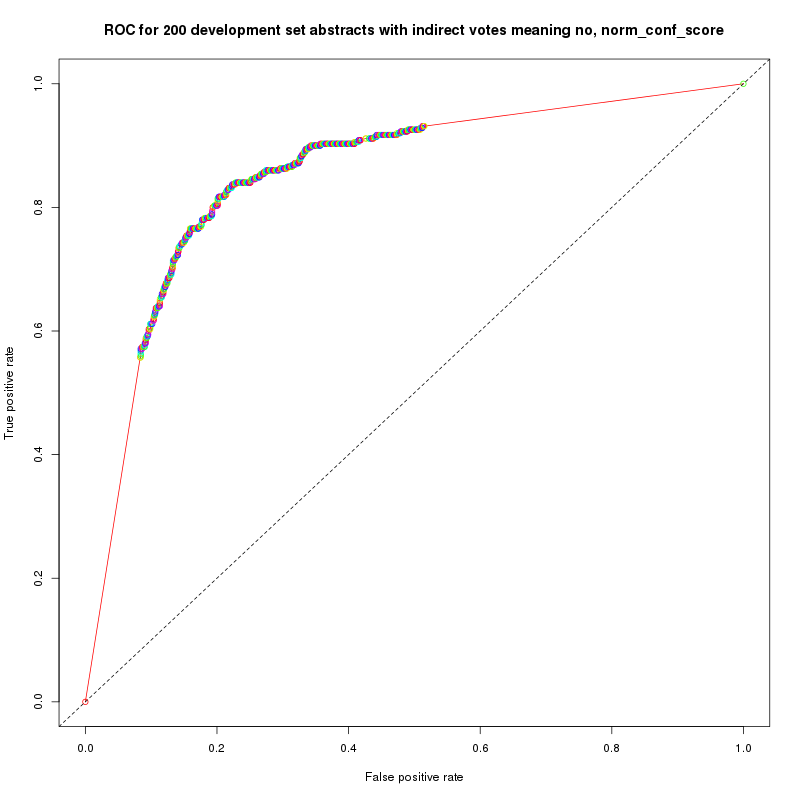

In [57]:
Image(fname)

In [58]:
fname = "data/roc/dev_set_200_abstracts_total_res.png"
title = "ROC for 200 development set abstracts with indirect votes meaning no, num_votes"
get_AUC_value(final_results, "num_votes", "in_gold", fname, title)

0.8518031891655744

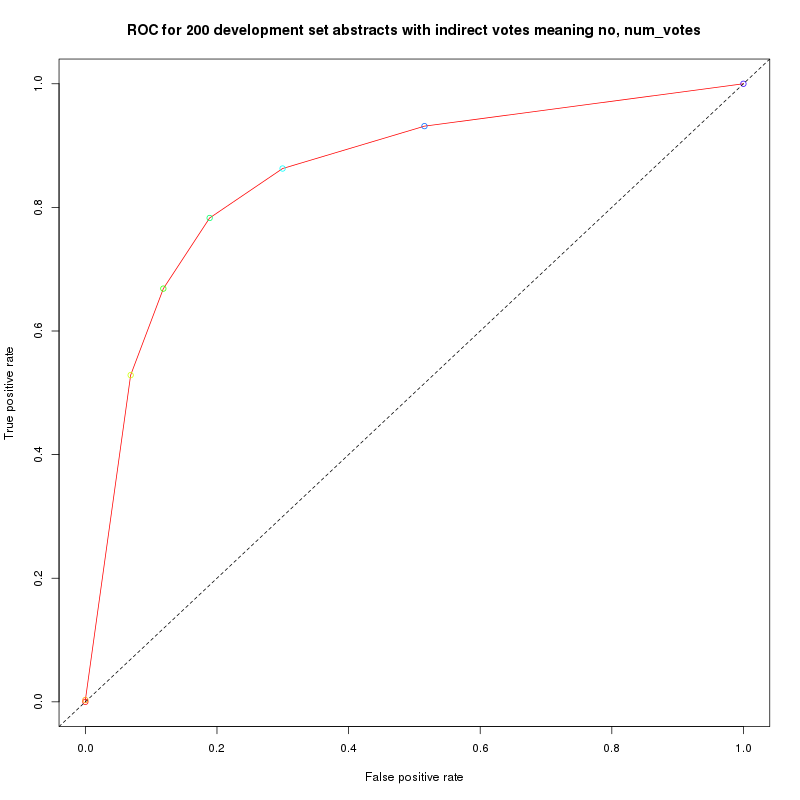

In [59]:
Image(fname)

### Performance without NER, using our own evaluation method

In [60]:
def plot_results(score_column, class_column, dataframe):
    res = all_F_scores(score_column, class_column, dataframe)
    res = res.sort("threshold")
    
    graph = res.plot(x = "threshold", figsize = (7, 7))
    graph.set_ylim((0, 1.1))

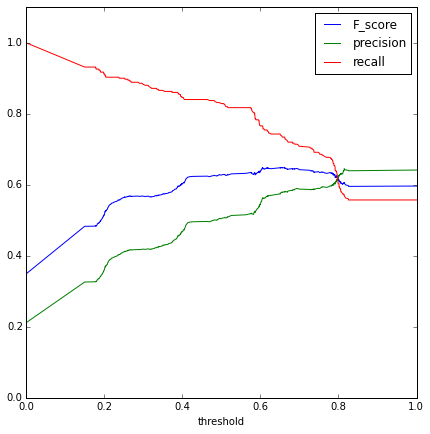

In [61]:
plot_results("norm_conf_score", "in_gold", final_results)

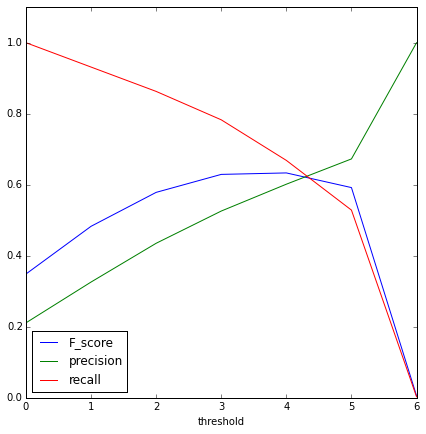

In [62]:
plot_results("num_votes", "in_gold", final_results)

---

### Evaluate using the official method:

Specifically, we define the following:

- A data point consists of a 3-tuple containing a document ID, a chemical concept ID and a disease concept ID.
- The set A consists of the set of annotated data points for the evaluation corpus.
- The set P consists of the set of data points predicted by the system for the evaluation corpus.
- Then the number of true positives (tp), false positives (fp), and false negatives (fn) are:

- tp=|A∩P|
- fp=|P-A|
- fn=|A-P|

The precision (p), recall (r) and f-score (f) are calculated using the typical definitions:

- p=tp/(tp+fp)
- r=tp/(tp+fn)
- f=(2∙p∙r)/(p+r)

In [63]:
def simple_repr(id_set):
    assert len(id_set) == 1
    temp = sorted(list(id_set))
    return "|".join(temp)

gold_relations = set()
for pmid, paper in gold_testset.items():
    for rel in paper.gold_relations:
        rep = "{0}#{1}+{2}".format(pmid, simple_repr(rel.chemical_id), simple_repr(rel.disease_id))
        gold_relations |= set([rep])

In [64]:
gold_relations

{'10074612#MESH:D008775+MESH:D001919',
 '10074612#MESH:D008775+MESH:D006323',
 '10074612#MESH:D008775+MESH:D007022',
 '10193809#MESH:D011692+MESH:D011507',
 '10225068#MESH:D008012+MESH:D011128',
 '10354657#MESH:D008094+MESH:D007037',
 '10411803#MESH:D015313+MESH:D000743',
 '10414674#MESH:D007660+MESH:D001791',
 '10414674#MESH:D007660+MESH:D006406',
 '10524660#MESH:D005996+MESH:D020326',
 '10524660#MESH:D009569+MESH:D020326',
 '10539815#MESH:D004232+MESH:D051437',
 '10539815#MESH:D004656+MESH:D051437',
 '10565806#MESH:C076029+MESH:D001714',
 '10692744#MESH:D000086+MESH:D005862',
 '10840460#MESH:D000171+MESH:D010146',
 '10840460#MESH:D003520+MESH:D003556',
 '10840460#MESH:D003520+MESH:D010146',
 '11009181#MESH:D007980+MESH:D004409',
 '11063349#MESH:D016559+MESH:D007674',
 '11063349#MESH:D016572+MESH:D007674',
 '11079278#MESH:D004280+MESH:D017202',
 '11185967#MESH:C005618+MESH:D012640',
 '11195262#MESH:D014635+MESH:D007177',
 '11208990#MESH:D004317+MESH:D009404',
 '11208990#MESH:D004317+M

In [65]:
def formater(s):
    if is_MeSH_id(s):
        return "MESH:{0}".format(s)
    
    assert s.startswith("MESH"), s
    assert is_MeSH_id(s.split(":")[1]), s
    return s

def get_list(s):
    return [formater(v) for v in s.split("|")]
    
def new_F_score(score_column, dataframe):
    EPSILON = 0.0000001
    
    res = defaultdict(list)
    for threshold in dataframe[score_column].unique():
        sub = dataframe.query("{0} > {1} or -{2} <= {0} - {1} <= {2}".format(score_column, threshold, EPSILON))
        
        guess_set = set()
        for idx, row in sub.iterrows():
            chem_id = row["chemical_id"]
            dise_id = row["disease_id"]
            pmid = row["pmid"]
            
            chem_id = get_list(chem_id)
            dise_id = get_list(dise_id)
            
            temp = []
            for cid in chem_id:
                for did in dise_id:
                    temp.append("{0}#{1}+{2}".format(int(pmid), cid, did))
                    
            guess_set |= set(temp)                    
                
        tp = len(gold_relations & guess_set)
        fp = len(guess_set - gold_relations)
        fn = len(gold_relations - guess_set)
        
        recall = tp / (tp + fp)
        precision = tp / (tp + fn)
        f_score = F_score(precision, recall)
        
        res["recall"].append(recall)
        res["precision"].append(precision)
        res["threshold"].append(threshold)
        res["F_score"].append(f_score)
        
    return pd.DataFrame(res)

In [66]:
official_res = new_F_score("norm_conf_score", final_results)

In [67]:
official_res.sort("F_score", ascending = False)

,F_score,precision,recall,threshold
473,0.615909,0.682620,0.561077,0.605632
110,0.615210,0.682620,0.559917,0.605486
358,0.614512,0.682620,0.558763,0.604984
361,0.614499,0.672544,0.565678,0.617223
454,0.614486,0.662469,0.572985,0.650832
418,0.614334,0.680101,0.560166,0.606454
445,0.614319,0.670025,0.567164,0.618698
63,0.614302,0.659950,0.574561,0.651542
323,0.613932,0.654912,0.577778,0.655322
225,0.613817,0.682620,0.557613,0.604946


In [68]:
official_res_vote = new_F_score("num_votes", final_results)

In [69]:
official_res_vote.sort("F_score", ascending = False)

,F_score,precision,recall,threshold
1,0.593156,0.589421,0.596939,4
5,0.593074,0.690176,0.519924,3
4,0.550226,0.765743,0.429379,2
2,0.548961,0.465995,0.667870,5
3,0.458832,0.821159,0.318359,1
0,0.333014,0.876574,0.205552,0
6,0.005025,0.002519,1.000000,6


In [70]:
def plot_it(res):
    res = res.sort("threshold")

    graph = res.plot(x = "threshold", figsize = (7, 7))
    graph.set_ylim((0, 1.1))

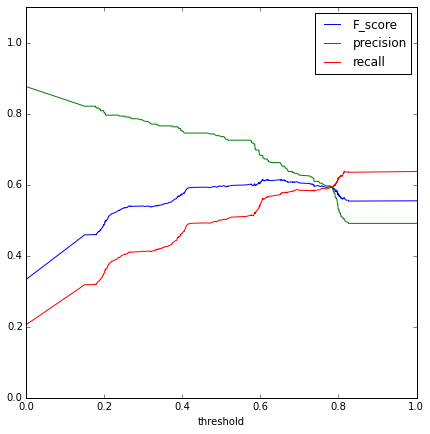

In [71]:
plot_it(official_res)

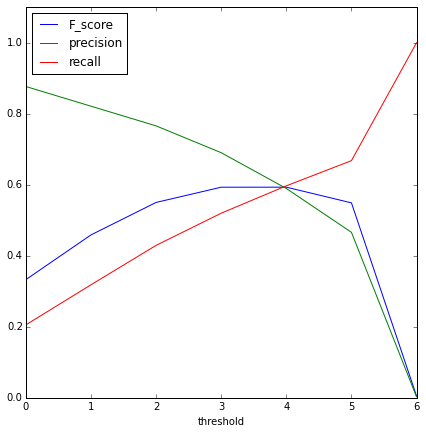

In [72]:
plot_it(official_res_vote)

We don't perform as well using the official method because in our own evaluation metric we are only measuring our performance for the subset of work we performed. In the official one we are penalized for not having let our job run to completion, as well as having cheaters. Overall though the performance drop isn't too big.

Now let's take the NER step into account: we will filter our concept ids which did not show up in the NER step.

---

### Results if we include spammer's judgments 

---

## Evaluate with NER step

### Filter crowd results to exclude work units which would have never been generated

In [73]:
sent_res_pos_no["findable"].value_counts(normalize = True)

True     0.823905
False    0.176095
dtype: float64

In [74]:
ner_sent_perf_no = aggregate_sentences(sent_res_pos_no.query("findable"))

In [75]:
ner_final_results = get_final_res(ner_sent_perf_no, abs_res_pos_no.query("findable"), ner_devset)

In [76]:
ner_final_results.head()

,chemical_id,disease_id,norm_conf_score,num_votes,pmid,rel_origin
563,C071741,D010146,0.000000,0,18006530,sentence_task
564,D015742,D010146,0.809157,4,18006530,sentence_task
587,D011718,D000857,1.000000,5,19674115,sentence_task
588,D011718,D033461,1.000000,5,19674115,sentence_task
589,D011718,D056486,1.000000,5,19674115,sentence_task


In [77]:
ner_final_results["in_gold"] = ner_final_results.loc[:, ["pmid", "chemical_id", "disease_id"]].apply(in_gold, axis = 1)

In [78]:
max_F_score("norm_conf_score", "in_gold", ner_final_results)

F_score      0.649718
precision    0.563725
recall       0.766667
threshold    0.605632
Name: 406, dtype: float64

In [79]:
max_F_score("num_votes", "in_gold", ner_final_results)

F_score      0.635995
precision    0.535308
recall       0.783333
threshold    3.000000
Name: 5, dtype: float64

In [80]:
ner_official_res = new_F_score("norm_conf_score", ner_final_results)

In [82]:
ner_official_res.sort("F_score", ascending = False).head(10)

,F_score,precision,recall,threshold
406,0.576020,0.586902,0.565534,0.605632
89,0.575309,0.586902,0.564165,0.605486
305,0.574599,0.586902,0.562802,0.604984
373,0.574257,0.584383,0.564477,0.605837
69,0.573892,0.586902,0.561446,0.604441
63,0.573186,0.586902,0.560096,0.603940
359,0.572491,0.581864,0.563415,0.606454
485,0.572482,0.586902,0.558753,0.603739
188,0.571779,0.586902,0.557416,0.603338
465,0.571429,0.579345,0.563725,0.606846


In [83]:
ner_official_res_vote = new_F_score("num_votes", ner_final_results)

In [84]:
ner_official_res_vote.sort("F_score", ascending = False)

,F_score,precision,recall,threshold
5,0.560859,0.591940,0.532880,3
1,0.545205,0.501259,0.597598,4
4,0.528226,0.659950,0.440336,2
2,0.491393,0.395466,0.648760,5
3,0.446203,0.710327,0.325260,1
0,0.325886,0.753149,0.207928,0


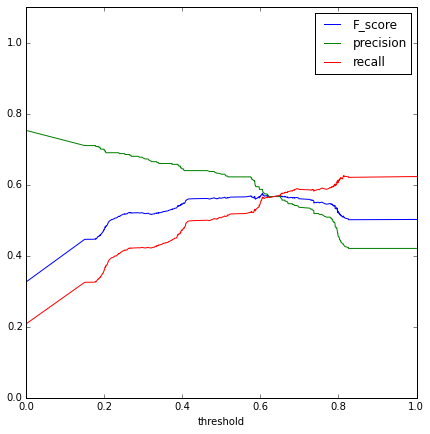

In [85]:
plot_it(ner_official_res)

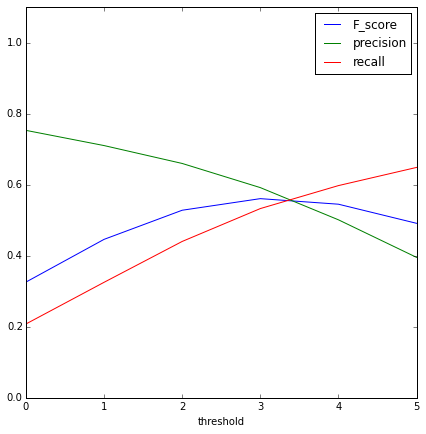

In [87]:
plot_it(ner_official_res_vote)